# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj2/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [117]:
from utils import cut # default cut function for seam finding section

In [118]:
from random import randint
# MY CODE: TEST IMAGES
def showImg(img):
    if isinstance(img, list):
        fig, axes = plt.subplots(1, len(img))
        for i in range(len(img)):
            axes[i].imshow(img[i], cmap='gray')
            axes[i].set_title('Image ' + str(i)), axes[i].set_xticks([]), axes[i].set_yticks([])
        return axes
    
    else:
        fig = plt.figure()
        plt.imshow(img, cmap='gray')
        plt.axis('off')

def label(axes, labels):
    for i in range(len(labels)):
        axes[i].set_title(labels[i])

### Part I: Randomly Sampled Texture (10 pts)

In [119]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    xRange = sample.shape[0]-patch_size
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros([out_size, out_size, 3]).astype(int)
    
#     xOrg = randint(0, xRange)
#     yOrg = randint(0, yRange)
                
#     showImg(sample[xOrg:xOrg+patch_size, yOrg:yOrg+patch_size, :])
    
    for x in range(0, out_size, patch_size):
        for y in range(0, out_size, patch_size):
            if x+patch_size < out_size and y+patch_size < out_size:
                xOrg = randint(0, xRange)
                yOrg = randint(0, yRange)
                randSamp = sample[xOrg:xOrg+patch_size, yOrg:yOrg+patch_size, :]
                outImg[x:x+patch_size, y:y+patch_size, :] = randSamp
    return outImg

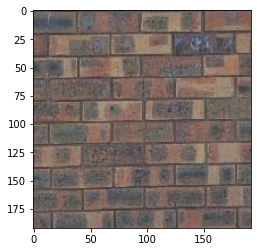

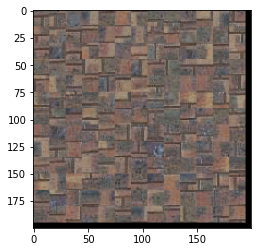

In [120]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [121]:
# T**2 -2I*T + I**2
#     (I-T)**2
    
T = np.zeros([3, 3])
I = np.zeros([9, 9])
M = np.zeros(T.shape)
M[:,0] = 1
T[0,0] = 5
T[1,1] = 5
I [4, 4] = 5
I [5, 5] = 5
def playSSD(T, I, M):
    print(M)
    print( (M*T**2).sum() - 2*cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I**2, ddepth=-1, kernel = M))
# playSSD(T, I, M)
print(M)
print(T)
print(M*T)
    

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[5. 0. 0.]
 [0. 5. 0.]
 [0. 0. 0.]]
[[5. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [352]:
def ssd_patch(T, I):
    M = T.flatten()
    totalColored = 0
    for i in range(len(M)):
        if M[i] > 0:
            M[i] = 1
            totalColored += 1
    
#     M = M/totalColored
    
    M = M.reshape(T.shape)
        
#     sampleM = np.flip(M, (0, 1))
    M = M.astype(float)
    T = T.astype(float)
    I = I.astype(float)
    

    ssd = ( ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M) )
#     print(-2*cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M))
#     print(cv2.filter2D(I ** 2, ddepth=-1, kernel=M))
#     print(- 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T))
    
    
    ssd = np.mean(ssd, axis=2)
    
    #debug
#     sortedSSD = np.argsort(ssd, axis=None)
#     outPatch = []
#     idx = 0
#     while len(outPatch) == 0:
#         flattenedCenter = sortedSSD[idx]
#         cords = np.unravel_index(flattenedCenter, ssd.shape)
#         outPatch = getPatch(I, cords, ssd.shape[0], T.shape[0])
#         idx += 1
#     showImg([T.astype(int), outPatch.astype(int)])
#     print(ssd.dtype)

    return ssd

def getPatch(img, center, maxLen, patchLen):
    xCorner = int(center[0] - patchLen/2)+1
    yCorner = int(center[1] - patchLen/2)+1
    if xCorner < 0 or yCorner < 0 or xCorner+patchLen >= maxLen or yCorner+patchLen >= maxLen:
        return []
    outPatch = img[xCorner:xCorner+patch_size, yCorner:yCorner+patch_size, :].copy()
    return outPatch
    
    
def choose_sample(ssdPatch, tol, patch_size, sample):    
    length = ssdPatch.shape[0]
    sortedSSD = np.argsort(ssdPatch, axis=None)
    
    
    
    randIdx = randint(0, tol)
    outPatch = []
    while len(outPatch) == 0:
        flattenedCenter = sortedSSD[randIdx]
#         cords = (flattenedCenter%length, int(flattenedCenter/length))
        cords = np.unravel_index(flattenedCenter, ssdPatch.shape)
        outPatch = getPatch(sample, cords, length, patch_size)
        randIdx += 1
    
    # display lowssd patches debug
#     for i in range(1):
#         flattenedCenter = sortedSSD[i]
#         cords = (flattenedCenter%length, int(flattenedCenter/length))
#         outPatch = getPatch(sample, cords, length, patch_size)   
#         showImg(outPatch)
    #end debug
    
#     randSamp = sample[cornerCords[0]:cornerCords[0]+patch_size, cornerCords[1]:cornerCords[1]+patch_size, :]
    return outPatch
    
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    xRange = sample.shape[0]-patch_size
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros([out_size, out_size, 3]).astype(int)
    
    #debug
    debugCount = 0
    
    for x in range(0, out_size, patch_size-overlap):
        for y in range(0, out_size, patch_size-overlap):
            if x > 0 or y > 0: #not first square
                if x+patch_size < out_size and y+patch_size < out_size:
                    ssdPatch = ssd_patch(outImg[x:x+patch_size, y:y+patch_size, :], sample[:,:,:])
                    
                    
                    goodSample = choose_sample(ssdPatch, tol, patch_size, sample)
                    
                    #debug
#                     showImg([outImg[x:x+patch_size, y:y+patch_size, :], goodSample])
                    
                    
                    
#                     # debug show ssd result compared to patch
#                     showImg(outImg)
#                     showImg([outImg[x:x+patch_size, y:y+patch_size, :], goodSample])
                    
#                     #debug
#                     debugCount += 1
#                     if debugCount > 1:
#                         break


                    outImg[x:x+patch_size, y:y+patch_size, :] = goodSample
                    
#                     showImg([outImg[x:x+patch_size, y:y+patch_size, :], goodSample])
                    
                
            elif x+patch_size < out_size and y+patch_size < out_size:
                xOrg = randint(0, xRange)
                yOrg = randint(0, yRange)
                randSamp = sample[xOrg:xOrg+patch_size, yOrg:yOrg+patch_size, :]
                
                outImg[x:x+patch_size, y:y+patch_size, :] = randSamp
    return outImg
    


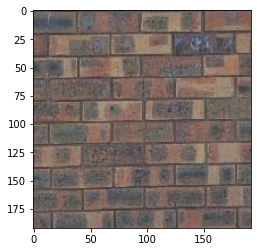

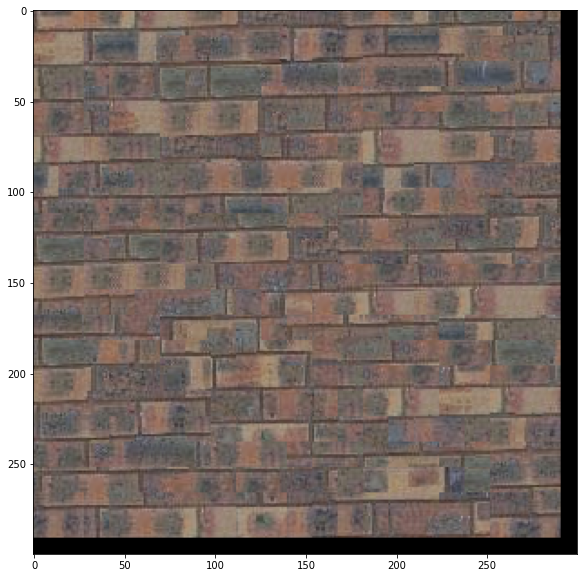

In [353]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [354]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [363]:
def path_ssd(patch1, patch2):
    ssdPatch = patch1 - patch2
    ssdPatch = ssdPatch **2
    return ssdPatch

def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros([out_size, out_size, 3]).astype(int) # init empty output
    
    for y in range(0, out_size, patch_size-overlap): # iterate through patches
        for x in range(0, out_size, patch_size-overlap):
            if x == 0 and y == 0: # first patch
                xOrg = randint(0, xRange) # randomly sample within range
                yOrg = randint(0, yRange)
                randSamp = sample[xOrg:xOrg+patch_size, yOrg:yOrg+patch_size, :] # sample patch from original image
                outImg[x:x+patch_size, y:y+patch_size, :] = randSamp # apply patch to output
                
            else: # not first patch
                if x+patch_size < out_size and y+patch_size < out_size: # if patch doesnt overlap out of bounds
                    outPatch = outImg[x:x+patch_size, y:y+patch_size, :]
                    ssdPatch = ssd_patch(outPatch, sample[:,:,:]) # get ssd matrix
                    goodSample = choose_sample(ssdPatch, tol, patch_size, sample) # choose good sample from ssd matrix
                    
                    
                    
                    ssdPath = []
                    if y > 0 and x > 0:
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)))
                        ssdPath = ssdPath * cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T
                    elif y == 0:
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)))
                    elif x == 0:
                        ssdPath = cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T
                    
                    for i in range(goodSample.shape[2]):
                        goodSample[:,:,i] = goodSample[:,:,i] * ssdPath
                        outPatch[:,:,i] = outPatch[:,:,i] * np.absolute(ssdPath-1)
                    
                    goodSample = goodSample + outPatch
                    
                    outImg[x:x+patch_size, y:y+patch_size, :] = goodSample # apply good patch to output
                    
           
    return outImg

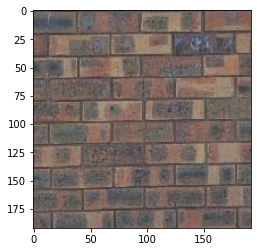

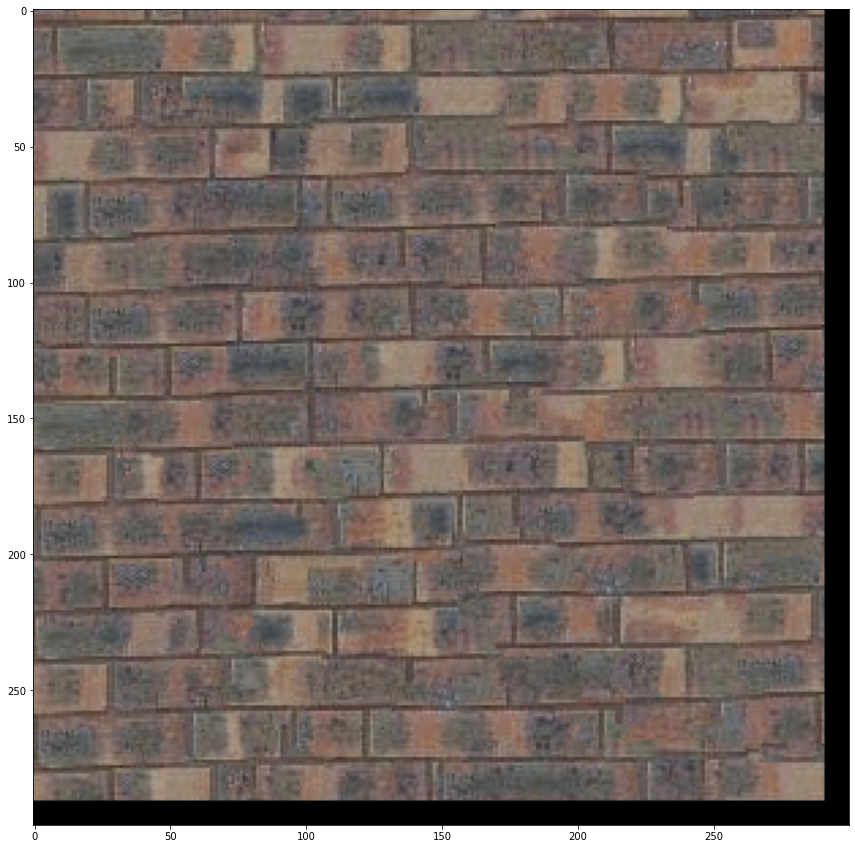

In [364]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [482]:
def gray_scale(img):
    img = np.float32(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def transfer_ssd(T, I, guidePatch, alpha, blurred_sample): # patch to fill, original sample image
    T = gray_scale(T)
    I = gray_scale(I)
    blurred_sample = gray_scale(blurred_sample)
    guidePatch = gray_scale(guidePatch)
    
    M = T.flatten() # copy T into M and flatten to iterate
    for i in range(len(M)): # truncate anything above 0 to 1
        if M[i] > 0:
            M[i] = 1
            
    
    M = M.reshape(T.shape) # reshape M to match T
        
    M = M.astype(float) # type cast for ssd
    T = T.astype(float)
    I = I.astype(float)
    guidePatch = guidePatch.astype(float)
    blurred_sample = blurred_sample.astype(float)
    unit = np.ones(M.shape).astype(float)
    
    #debug
#     showImg(blurred_sample)
#     showImg(guidePatch)
#     return
    
    ssd_patch = ( ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M) )
    ssd_guide = ( ((unit*guidePatch)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = unit*guidePatch) + cv2.filter2D(I ** 2, ddepth=-1, kernel=unit) )
    
    ssd_combo = ssd_patch*alpha + ssd_guide*(1-alpha)    
    
    #debug
#     print(ssd_guide)
#     return ssd_guide

    return ssd_combo

def getPatch(sample, center, patchLen): # original image, center pixel cords,
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size 
    xCorner = int(center[0] - patchLen/2)+1  # get corner pixels (center - half patch length and +1 to round up)
    yCorner = int(center[1] - patchLen/2)+1
    if xCorner < 0 or yCorner < 0 or xCorner+patchLen >= xRange or yCorner+patchLen >= yRange: # if corners out of range, return nothing
        return []
    outPatch = sample[xCorner:xCorner+patch_size, yCorner:yCorner+patch_size, :].copy() # else return patch from sample
    return outPatch

def choose_sample(ssdPatch, tol, patch_size, sample): # ssd matrix, tolerance, patch size, original image    
    sortedSSD = np.argsort(ssdPatch, axis=None) # sort ssd matrix and collapse into 1 dimension
    randIdx = randint(0, tol) # randomly choose low ssd center pixel within tol
    outPatch = [] # init empty output patch
    while len(outPatch) == 0: # while the chosen patch is invalid
        flattenedCenter = sortedSSD[randIdx] # get 1d center cord
        cords = np.unravel_index(flattenedCenter, ssdPatch.shape) # convert 1d cord to 2d cord
        outPatch = getPatch(sample, cords, patch_size) # sample patch from image
        randIdx += 1 # if the patch is invalid, move to next lowest pixel in ssd
    
#     #debug
#     display = []
#     for i in range(5):
#         flattenedCenter = sortedSSD[i]
#         cords = np.unravel_index(flattenedCenter, ssdPatch.shape)
#         outPatch = getPatch(sample, cords, patch_size)
#         display.append(outPatch)
#     showImg(display)
    

    return outPatch
    
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    guidance_im = cv2.GaussianBlur(guidance_im, (31, 31), 5) # for 31x31 blur kernel with sigma=5 
    blurred_sample = cv2.GaussianBlur(sample, (31, 31), 5) # for 31x31 blur kernel with sigma=5

    
    # setup
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros(guidance_im.shape).astype(int) # init empty output

    out_width = guidance_im.shape[0] 
    out_height = guidance_im.shape[1] 
    
    #debug
    debugCount = 0
    
    # iterate
    for x in range(0, out_width, patch_size-overlap): # iterate through patches
        for y in range(0, out_height, patch_size-overlap):
            if x+patch_size < out_width and y+patch_size < out_height: # if patch doesnt overlap out of bounds
                outPatch = outImg[x:x+patch_size, y:y+patch_size, :].copy()
                guidePatch = guidance_im[x:x+patch_size, y:y+patch_size, :].copy()
                if outPatch.shape != guidePatch.shape:
                    print(debugCount)
                    showImg(outPatch)

                ssdPatch = transfer_ssd(outPatch, sample[:,:,:], guidePatch, alpha, blurred_sample) # get ssd matrix
                
                #debug
#                 return
                
#                 #debug
#                 showImg([outPatch, guidePatch])

                goodSample = choose_sample(ssdPatch, tol, patch_size, sample) # choose good sample from ssd matrix
                
                
#                 #debug
                if debugCount > 15:
                    pass
                debugCount += 1
                if x != 0 or y != 0:
                    # cutting
                    ssdPath = []
                    if y > 0 and x > 0: # if within image, cut vertically and horizontally
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)))
                        ssdPath = ssdPath * cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T # mask the mask
                    elif y == 0: # if on x axis, only cut vertically (horizontal in display image)
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2))) 
                    elif x == 0: # if on y axis, only cut horixontally (vertical in display image)
                        ssdPath = cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T

                    # apply mask
                    for i in range(goodSample.shape[2]): # mask all 3 RGB channels
                        goodSample[:,:,i] = goodSample[:,:,i] * ssdPath # apply mask to new patch
                        outPatch[:,:,i] = outPatch[:,:,i] * np.absolute(ssdPath-1) # apply inverted mask to existing patch


                # combine patches and apply
                goodSample = goodSample + outPatch # overlay patches
                outImg[x:x+patch_size, y:y+patch_size, :] = goodSample # apply cut patch to output
           
    return outImg

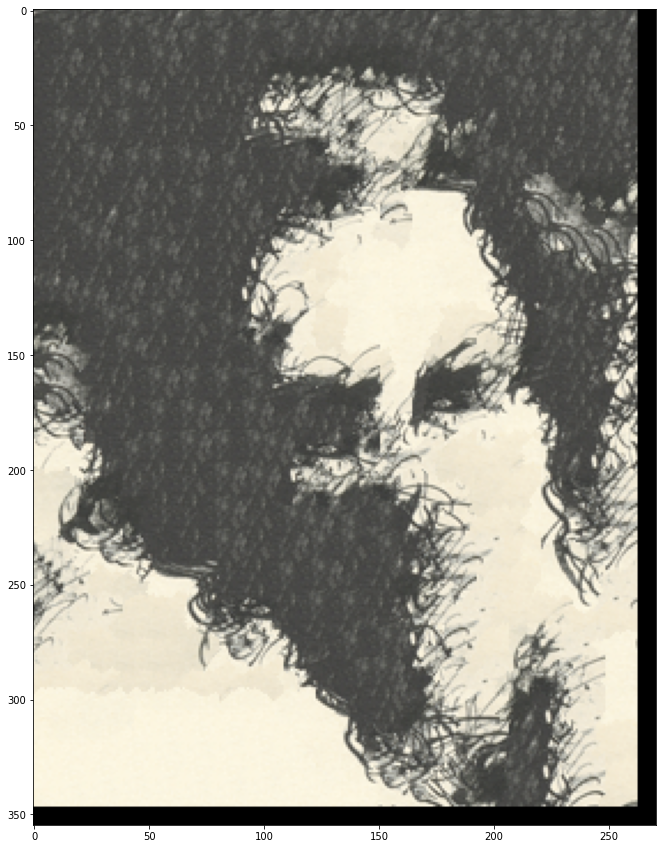

In [486]:
# load/process appropriate input texture and guidance images
sample_text = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(sample_text), cv2.COLOR_BGR2RGB)
sample_guide = 'samples/feynman.tiff' 
guidance_img = cv2.cvtColor(cv2.imread(sample_guide), cv2.COLOR_BGR2RGB)


patch_size = 25
overlap = 11
tol = 3
alpha = 0.7
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).